In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-12-14 03:46:33.269700: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:


# CSV 파일 경로 지정
file_path = 'AAOS.csv'

# CSV 파일 읽기
data = pd.read_csv(file_path, encoding='cp949')

data.iloc[:, 2:] = data.iloc[:, 2:].apply(lambda col: col.fillna(col.mean()))
data = data['1.5M 평균 기온(°C)']  # 'temperature_column_name'에는 실제 온도 데이터가 있는 열의 이름을 넣어주세요

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(np.array(data).reshape(-1, 1))




Epoch 1/100


2023-12-14 03:46:36.127963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-14 03:46:36.128895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-14 03:46:36.129501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4845/4845 - 5s - loss: 0.0136 - val_loss: 0.0042 - 5s/epoch - 1ms/step
Epoch 2/100
4845/4845 - 4s - loss: 0.0046 - val_loss: 0.0052 - 4s/epoch - 745us/step
Epoch 3/100
4845/4845 - 4s - loss: 0.0043 - val_loss: 0.0035 - 4s/epoch - 748us/step
Epoch 4/100
4845/4845 - 4s - loss: 0.0043 - val_loss: 0.0037 - 4s/epoch - 753us/step
Epoch 5/100
4845/4845 - 4s - loss: 0.0041 - val_loss: 0.0035 - 4s/epoch - 783us/step
Epoch 6/100
4845/4845 - 4s - loss: 0.0042 - val_loss: 0.0036 - 4s/epoch - 808us/step
Epoch 7/100
4845/4845 - 4s - loss: 0.0041 - val_loss: 0.0034 - 4s/epoch - 877us/step
Epoch 8/100
4845/4845 - 4s - loss: 0.0040 - val_loss: 0.0039 - 4s/epoch - 892us/step
Epoch 9/100
4845/4845 - 4s - loss: 0.0040 - val_loss: 0.0033 - 4s/epoch - 892us/step
Epoch 10/100
4845/4845 - 4s - loss: 0.0040 - val_loss: 0.0035 - 4s/epoch - 875us/step
Epoch 11/100
4845/4845 - 4s - loss: 0.0040 - val_loss: 0.0042 - 4s/epoch - 873us/step
Epoch 12/100
4845/4845 - 4s - loss: 0.0040 - val_loss: 0.0034 - 4s/epoch - 87

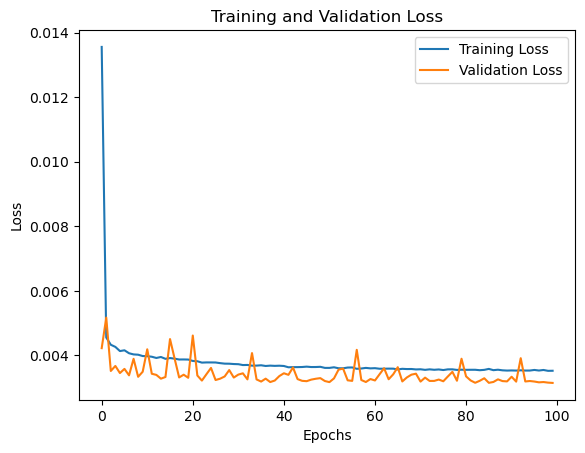

In [3]:
# 데이터셋 생성
def create_dataset(dataset, look_back=1, look_forward=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-look_forward+1):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back:i + look_back + look_forward, 0])
    return np.array(X), np.array(Y)

# 입력 파라미터 설정
look_back = 30  # 몇 개의 이전 데이터를 기반으로 예측할지 설정
look_forward = 7  # 몇 일 앞까지 예측할지 설정
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]

# 데이터셋 생성
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# LSTM 입력 데이터 형태로 변환
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# LSTM 모델 정의
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(look_forward))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, validation_data=(testX, testY))

# 훈련과정에서의 loss를 확인하고 그래프로 표시
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:

# 예측 수행
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# 정규화된 데이터를 역변환하여 실제 값으로 변환
trainPredict = scaler.inverse_transform(trainPredict[:, -1].reshape(-1, 1))
trainY = scaler.inverse_transform(trainY[:, -1].reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict[:, -1].reshape(-1, 1))
testY = scaler.inverse_transform(testY[:, -1].reshape(-1, 1))



152/152 [==============================] - 0s 499us/step


2023-12-14 03:53:21.016608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-14 03:53:21.017854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-14 03:53:21.018633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

75/75 [==============================] - 0s 430us/step


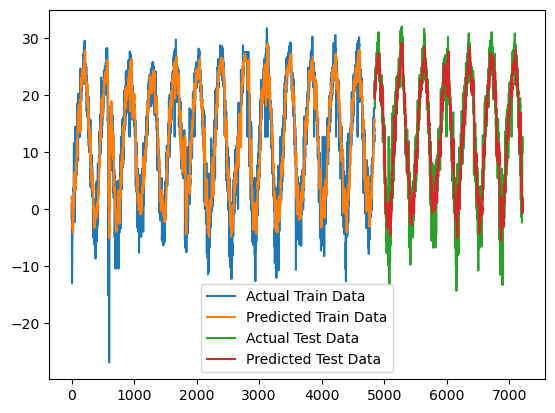

In [5]:
# 예측 결과 시각화
# plt.plot(trainY.flatten(), label='Actual Train Data')
plt.plot(trainY.flatten(), label='Actual Train Data')
plt.plot(trainPredict.flatten(), label='Predicted Train Data')
plt.plot(np.arange(len(trainY.flatten()), len(trainY.flatten()) + len(testY.flatten())),
         testY.flatten(), label='Actual Test Data')
plt.plot(np.arange(len(trainY.flatten()), len(trainY.flatten()) + len(testY.flatten())),
         testPredict.flatten(), label='Predicted Test Data')

# x 축에 날짜 표시
# date_range_train = data['일시'][:train_size]
# date_range_test = data['일시'][train_size:train_size + len(testY)]

# plt.xticks(
#     np.arange(0, len(trainY) + len(testY), step=365),  # 365는 1년을 의미, 조절 가능
#     labels=pd.concat([date_range_train, date_range_test]).iloc[::365],  # 365는 1년을 의미, 조절 가능
#     rotation=45
# )


plt.legend()
plt.show()